# Radon-Transform (CPU)

## Setup

In [1]:
from math import sin, cos
import typing
import torch
import torchvision
import matplotlib.pyplot as plt
import torch_radon
import radon
#rm -r ~/.cache/torch_extensions/py310_cu116/*
#BUG "/usr/include/c++/11/bits/std_function.h:435:145: error: parameter packs not expanded with ‘...’" --> https://github.com/NVIDIA/nccl/issues/650#issuecomment-1145173577

In [2]:
def shepp_logan_phantom(n):
    phantom = torch.zeros((n,n))
    centers = torch.tensor([[0, 0], [0, -0.0184], [0.11, 0], [-0.11, 0], [0, 0.175], [0, 0.05], [0, -0.05], [-0.04, -0.3025], [0, -0.3025], [0.03, -0.3025]])
    axes = torch.tensor([[0.69, 0.92], [0.6624, 0.874], [0.11, 0.31], [0.16, 0.41], [0.21, 0.25], [0.046, 0.046], [0.046, 0.046], [0.046, 0.023], [0.023, 0.023], [0.023, 0.046]])
    theta = torch.tensor([0, 0, -0.31415926535, 0.31415926535, 0, 0, 0, 0, 0, 0])
    intensity = torch.tensor([2, -1.0, -0.2, -0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    x,y = torch.meshgrid(torch.linspace(-0.5, 0.5, n), -torch.linspace(-0.5, 0.5, n), indexing="ij")
    with torch.no_grad():
        for i in range(10):
            phantom[
                torch.square((x-centers[i,0])*cos(theta[i])+(y-centers[i,1])*sin(theta[i]))/((axes[i,0]/2.0)**2)+
                torch.square((x-centers[i,0])*sin(theta[i])-(y-centers[i,1])*cos(theta[i]))/((axes[i,1]/2.0)**2)
                <= 1.0] += intensity[i]
    return phantom.T

In [3]:
img = torch.zeros((1,1,31,31))
img[0, 0, 10:20, 10:20] = 1.0
sino = radon.radon_forward(img, torch.tensor([3.0925, 3.1416, 3.1907]), torch.tensor([-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7]).to(torch.float32))

theta: 3.0925
theta: 7.15256e-06
theta: 0.0491073


theta: 2.15985
theta: 2.20893
theta: 2.25802
theta: 2.30711
theta: 2.35619
theta: 2.40528
theta: 2.45437
theta: 2.50346
theta: 2.55254
theta: 2.60163
theta: 2.65072
theta: 2.69981
theta: 2.74889
theta: 2.79798
theta: 2.84707
theta: 2.89616
theta: 2.94524
theta: 2.99433
theta: 3.04342
theta: 3.09251
theta: 0
theta: 0.0490873
theta: 0.0981748
theta: 0.147262
theta: 0.19635
theta: 0.245437
theta: 0.294524
theta: 0.343612
theta: 0.392699
theta: 0.441786
theta: 0.490874
theta: 0.539961
theta: 0.589049
theta: 0.638136
theta: 0.687223
theta: 0.736311
theta: 0.785398
theta: 0.834486
theta: 0.883573
theta: 0.93266
theta: 0.981748
tensor(3.0925)
tensor(3.1416)
tensor(3.1907)
00.000, 00.000, 00.000, 00.000, 00.000, 00.000, 10.012, 10.012, 10.012, 10.012, 10.012, 10.012, 10.012, 10.012, 10.012, 10.012, 00.000, 00.000, 00.000, 00.000, 
00.000, 00.000, 00.000, 00.000, 00.000, 10.000, 10.000, 10.000, 10.000, 10.000, 10.000, 10.000, 10.000, 10.000, 10.000, 00.000, 00.000, 00.000, 00.000, 00.000, 
00.0

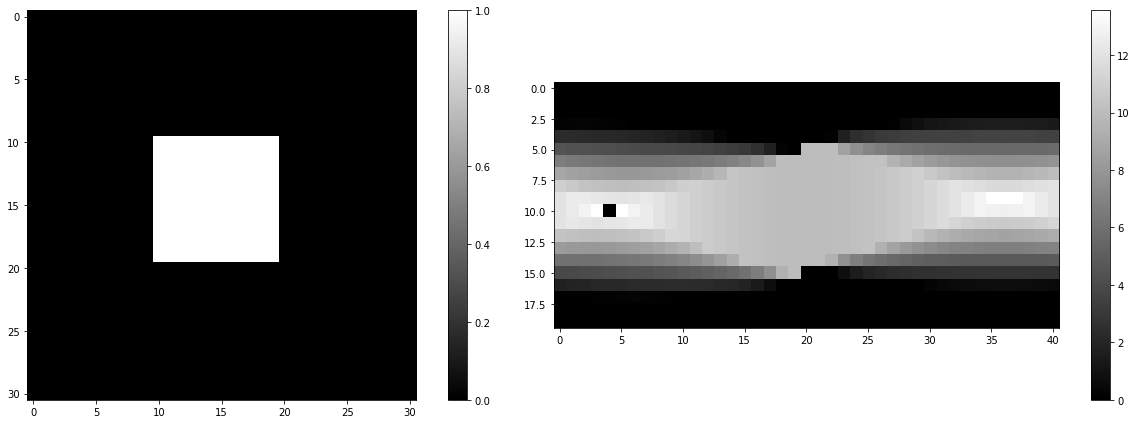

In [4]:
img = torch.zeros((1,1,31,31))
img[0, 0, 10:20, 10:20] = 1.0
delta_theta = 3.14159265359/256.0
pi_half = 3.14159265359/2.0
sino = radon.radon_forward(img, torch.linspace(0, 3.14159265359*2.0, 129)[:-1][44:85], torch.arange(-10,10).to(torch.float32))
print(torch.linspace(0, 3.14159265359*2.0, 129)[:-1][44:85][19])
print(torch.linspace(0, 3.14159265359*2.0, 129)[:-1][44:85][20])
print(torch.linspace(0, 3.14159265359*2.0, 129)[:-1][44:85][21])
[print(f"{sino[0,0,19,i]:06.3f}, ", end="") for i in range(sino.shape[3])]
print()
[print(f"{sino[0,0,20,i]:06.3f}, ", end="") for i in range(sino.shape[3])]
print()
[print(f"{sino[0,0,21,i]:06.3f}, ", end="") for i in range(sino.shape[3])]

plt.subplots(1,2,figsize=(18,6))
plt.subplot(1,2,1)
plt.imshow(img[0,0], cmap="gray", interpolation="nearest")
plt.colorbar()
plt.subplot(1,2,2)
#plt.imshow(torch.cat((sino_2[0,0,:128,:], torch.flip(sino_2[0,0,128:,:], (0,)))).mT, cmap="gray")
plt.imshow(sino[0,0].mT, cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()

#plt.figure(figsize=(6,6))
#plt.imshow((sino4[0,0,:128,:]-sino4[0,0,128:,:]).mT, cmap="gray")
#plt.colorbar()
#plt.tight_layout()
#plt.show()

## Examples

### Python functions

theta: 0
theta: 0.0122718
theta: 0.0245437
theta: 0.0368155
theta: 0.0490874
theta: 0.0613592
theta: 0.0736311
theta: 0.0859029
theta: 0.0981748
theta: 0.110447
theta: 0.122718
theta: 0.13499
theta: 0.147262
theta: 0.159534
theta: 0.171806
theta: 0.184078
theta: 0.19635
theta: 0.208621
theta: 0.220893
theta: 0.233165
theta: 0.245437
theta: 0.257709
theta: 0.269981
theta: 0.282252
theta: 0.294524
theta: 0.306796
theta: 0.319068
theta: 0.33134
theta: 0.343612
theta: 0.355884
theta: 0.368155
theta: 0.380427
theta: 0.392699
theta: 0.404971
theta: 0.417243
theta: 0.429515
theta: 0.441786
theta: 0.454058
theta: 0.46633
theta: 0.478602
theta: 0.490874
theta: 0.503146
theta: 0.515418
theta: 0.527689
theta: 0.539961
theta: 0.552233
theta: 0.564505
theta: 0.576777
theta: 0.589049
theta: 0.60132
theta: 0.613592
theta: 0.625864
theta: 0.638136
theta: 0.650408
theta: 0.66268
theta: 0.674952
theta: 0.687223
theta: 0.699495
theta: 0.711767
theta: 0.724039
theta: 0.736311
theta: 0.748583
theta: 0.7608

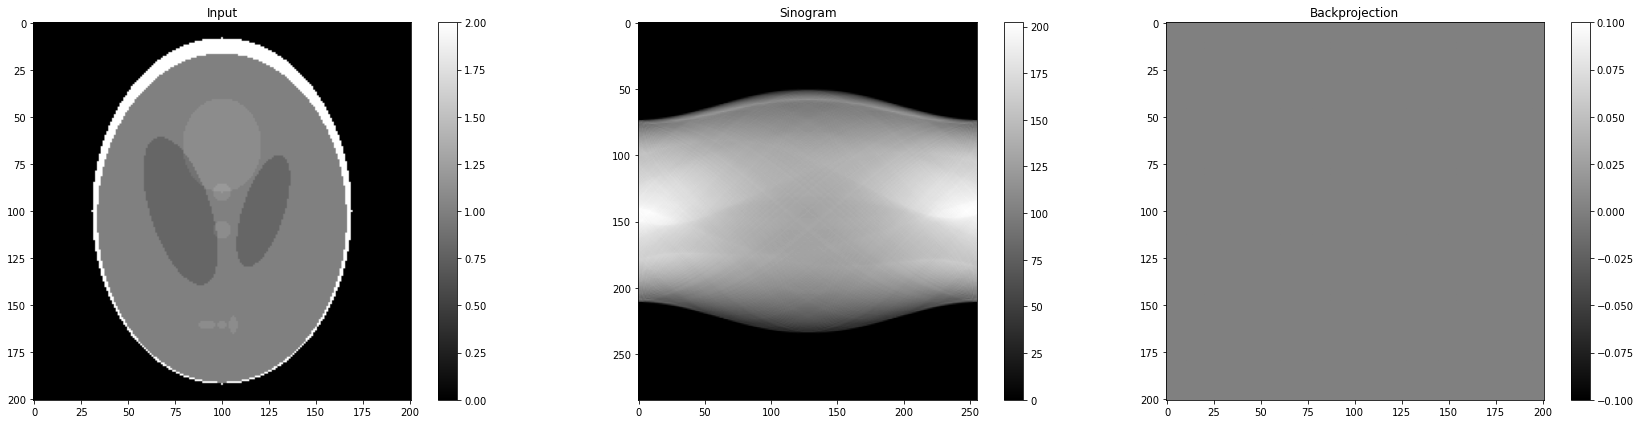

In [5]:
img0 = shepp_logan_phantom(201).contiguous().unsqueeze(0).unsqueeze(0).requires_grad_(True)
#img0 = next(iter(torchvision.datasets.MNIST("/data/datasets/", True, torchvision.transforms.ToTensor(), download=True)))[0].unsqueeze(0).requires_grad_(True)
plt.subplots(1, 3, figsize=(24,6))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(img0[0,0].detach(), cmap="gray")
plt.colorbar()
sino0 = radon.radon_forward(img0)
plt.subplot(1, 3, 2)
plt.title("Sinogram")
plt.imshow(sino0[0,0].detach().mT, cmap="gray")
plt.colorbar()
recon0 = radon.radon_backward(sino0, img0.shape[3])
plt.subplot(1, 3, 3)
plt.title("Backprojection")
plt.imshow(recon0[0,0].detach(), cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()

### Torch-Autograd-Function

theta: 0
theta: 0.0122718
theta: 0.0245437
theta: 0.0368155
theta: 0.0490874
theta: 0.0613592
theta: 0.0736311
theta: 0.0859029
theta: 0.0981748
theta: 0.110447
theta: 0.122718
theta: 0.13499
theta: 0.147262
theta: 0.159534
theta: 0.171806
theta: 0.184078
theta: 0.19635
theta: 0.208621
theta: 0.220893
theta: 0.233165
theta: 0.245437
theta: 0.257709
theta: 0.269981
theta: 0.282252
theta: 0.294524
theta: 0.306796
theta: 0.319068
theta: 0.33134
theta: 0.343612
theta: 0.355884
theta: 0.368155
theta: 0.380427
theta: 0.392699
theta: 0.404971
theta: 0.417243
theta: 0.429515
theta: 0.441786
theta: 0.454058
theta: 0.46633
theta: 0.478602
theta: 0.490874
theta: 0.503146
theta: 0.515418
theta: 0.527689
theta: 0.539961
theta: 0.552233
theta: 0.564505
theta: 0.576777
theta: 0.589049
theta: 0.60132
theta: 0.613592
theta: 0.625864
theta: 0.638136
theta: 0.650408
theta: 0.66268
theta: 0.674952
theta: 0.687223
theta: 0.699495
theta: 0.711767
theta: 0.724039
theta: 0.736311
theta: 0.748583
theta: 0.7608

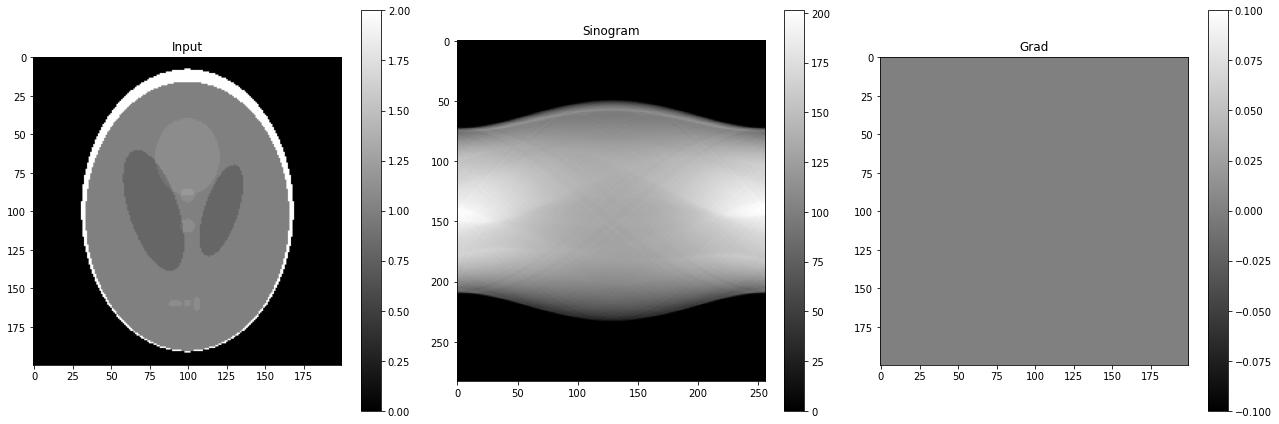

In [6]:
img1 = shepp_logan_phantom(200).contiguous().unsqueeze(0).unsqueeze(0).requires_grad_(True)
#img1 = next(iter(torchvision.datasets.MNIST("/data/datasets/", True, torchvision.transforms.ToTensor(), download=True)))[0].unsqueeze(0).requires_grad_(True)
plt.subplots(1, 3, figsize=(18,6))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(img1[0,0].detach(), cmap="gray")
plt.colorbar()
sino1 = radon.RadonTransformFunc.apply(img1, torch.linspace(0, 3.14159265359, 257)[:-1])
plt.subplot(1, 3, 2)
plt.title("Sinogram")
plt.imshow(sino1[0,0].detach().mT, cmap="gray")
plt.colorbar()
sino1.sum().backward()
recon1 = typing.cast(torch.Tensor, img1.grad)
plt.subplot(1, 3, 3)
plt.title("Grad")
plt.imshow(recon1[0,0].detach(), cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()

### Torch-Module

theta: 0
theta: 0.0122718
theta: 0.0245437
theta: 0.0368155
theta: 0.0490874
theta: 0.0613592
theta: 0.0736311
theta: 0.0859029
theta: 0.0981748
theta: 0.110447
theta: 0.122718
theta: 0.13499
theta: 0.147262
theta: 0.159534
theta: 0.171806
theta: 0.184078
theta: 0.19635
theta: 0.208621
theta: 0.220893
theta: 0.233165
theta: 0.245437
theta: 0.257709
theta: 0.269981
theta: 0.282252
theta: 0.294524
theta: 0.306796
theta: 0.319068
theta: 0.33134
theta: 0.343612
theta: 0.355884
theta: 0.368155
theta: 0.380427
theta: 0.392699
theta: 0.404971
theta: 0.417243
theta: 0.429515
theta: 0.441786
theta: 0.454058
theta: 0.46633
theta: 0.478602
theta: 0.490874
theta: 0.503146
theta: 0.515418
theta: 0.527689
theta: 0.539961
theta: 0.552233
theta: 0.564505
theta: 0.576777
theta: 0.589049
theta: 0.60132
theta: 0.613592
theta: 0.625864
theta: 0.638136
theta: 0.650408
theta: 0.66268
theta: 0.674952
theta: 0.687223
theta: 0.699495
theta: 0.711767
theta: 0.724039
theta: 0.736311
theta: 0.748583
theta: 0.7608

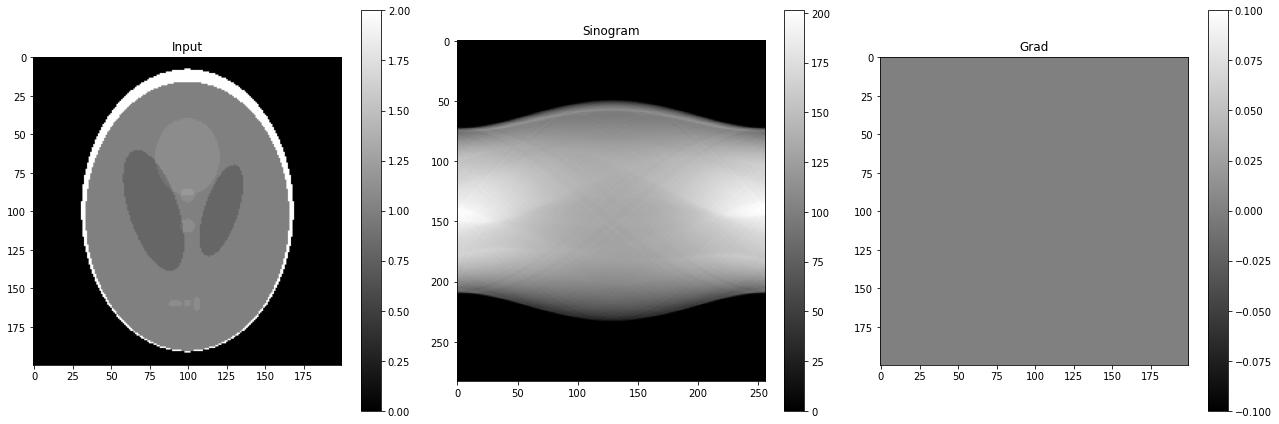

In [7]:
radon_trans = radon.RadonTransform()
img2 = shepp_logan_phantom(200).contiguous().unsqueeze(0).unsqueeze(0).requires_grad_(True)
#img1 = next(iter(torchvision.datasets.MNIST("/data/datasets/", True, torchvision.transforms.ToTensor(), download=True)))[0].unsqueeze(0).requires_grad_(True)
plt.subplots(1, 3, figsize=(18,6))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(img2[0,0].detach(), cmap="gray")
plt.colorbar()
sino2 = radon_trans(img2)
plt.subplot(1, 3, 2)
plt.title("Sinogram")
plt.imshow(sino2[0,0].detach().mT, cmap="gray")
plt.colorbar()
sino2.sum().backward()
recon2 = typing.cast(torch.Tensor, img2.grad)
plt.subplot(1, 3, 3)
plt.title("Grad")
plt.imshow(recon2[0,0].detach(), cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()

## Debug

### Torch-Radon

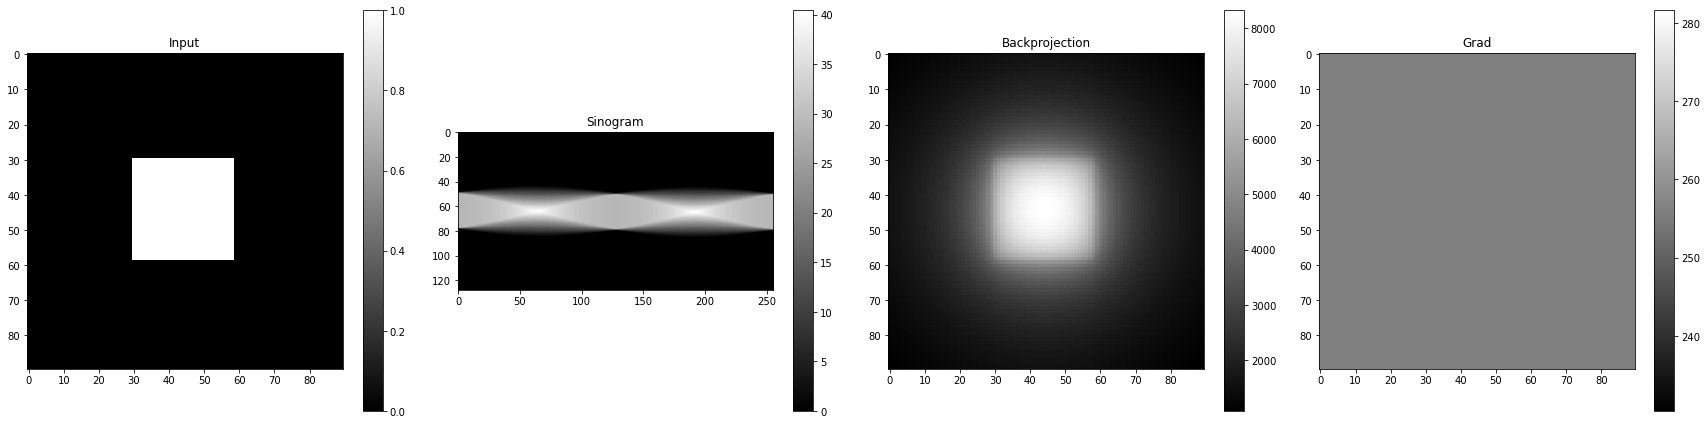

In [8]:
torchradon = torch_radon.Radon(90, torch.linspace(0.0, 3.14159265359, 256), 128, 1)
img3 = torch.zeros((1,1,90,90), device="cuda")
img3[0, 0, 30:59,30:59] = 1.0
img3.requires_grad = True
plt.subplots(1, 4, figsize=(24,6))
plt.subplot(1, 4, 1)
plt.title("Input")
plt.imshow(img3.detach().to("cpu")[0,0], cmap="gray")
plt.colorbar()
sino3 = torchradon.forward(img3)
plt.subplot(1, 4, 2)
plt.title("Sinogram")
plt.imshow(sino3.detach().to("cpu")[0,0].mT, cmap="gray")
plt.colorbar()
recon3 = torchradon.backward(sino3)
plt.subplot(1, 4, 3)
plt.title("Backprojection")
plt.imshow(recon3.detach().to("cpu")[0,0], cmap="gray")
plt.colorbar()
sino3.sum().backward()
plt.subplot(1, 4, 4)
plt.title("Grad")
plt.imshow(typing.cast(torch.Tensor, img3.grad).detach().to("cpu")[0,0], cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()

### Ours

theta: 0
theta: 0.0122718
theta: 0.0245437
theta: 0.0368155
theta: 0.0490874
theta: 0.0613592
theta: 0.0736311
theta: 0.0859029
theta: 0.0981748
theta: 0.110447
theta: 0.122718
theta: 0.13499
theta: 0.147262
theta: 0.159534
theta: 0.171806
theta: 0.184078
theta: 0.19635
theta: 0.208621
theta: 0.220893
theta: 0.233165
theta: 0.245437
theta: 0.257709
theta: 0.269981
theta: 0.282252
theta: 0.294524
theta: 0.306796
theta: 0.319068
theta: 0.33134
theta: 0.343612
theta: 0.355884
theta: 0.368155
theta: 0.380427
theta: 0.392699
theta: 0.404971
theta: 0.417243
theta: 0.429515
theta: 0.441786
theta: 0.454058
theta: 0.46633
theta: 0.478602
theta: 0.490874
theta: 0.503146
theta: 0.515418
theta: 0.527689
theta: 0.539961
theta: 0.552233
theta: 0.564505
theta: 0.576777
theta: 0.589049
theta: 0.60132
theta: 0.613592
theta: 0.625864
theta: 0.638136
theta: 0.650408
theta: 0.66268
theta: 0.674952
theta: 0.687223
theta: 0.699495
theta: 0.711767
theta: 0.724039
theta: 0.736311
theta: 0.748583
theta: 0.7608

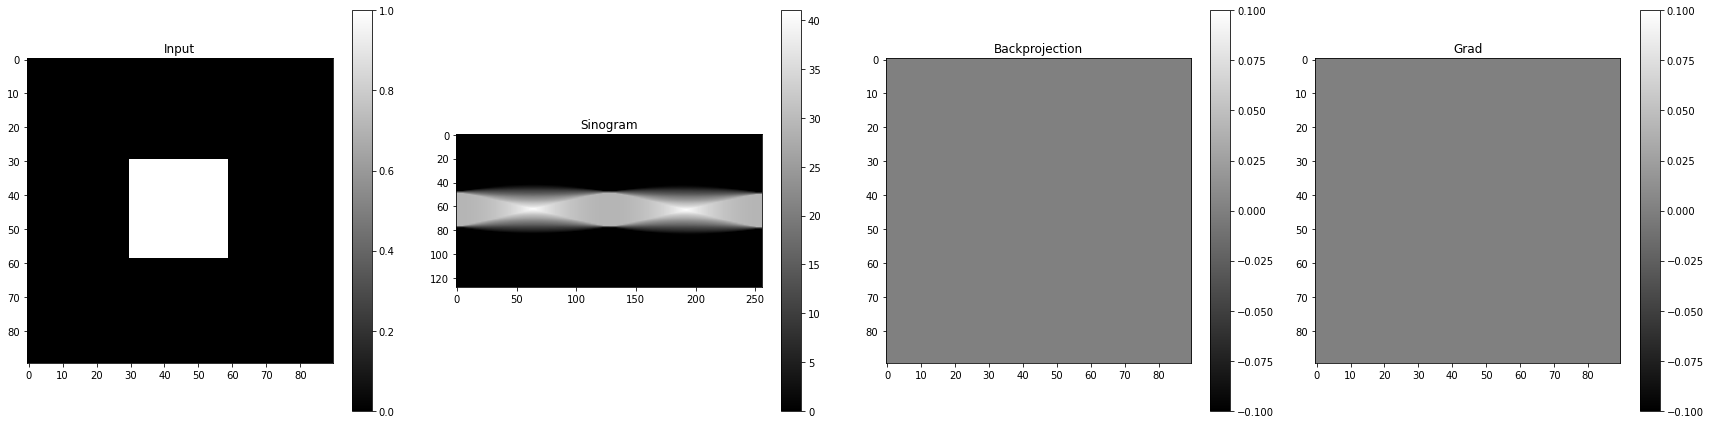

In [9]:
img4 = torch.zeros((1,1,90,90))
img4[0, 0, 30:59,30:59] = 1.0
#img4[0, 0, 30, 30] = 1.0
plt.subplots(1, 4, figsize=(24,6))
plt.subplot(1, 4, 1)
plt.title("Input")
plt.imshow(img4[0,0], cmap="gray")
plt.colorbar()
sino4 = radon.RadonTransformFunc.apply(img4, torch.linspace(0, 3.14159265359, 257)[:-1])
plt.subplot(1, 4, 2)
plt.title("Sinogram")
plt.imshow(sino4[0,0].mT, cmap="gray")
plt.colorbar()
recon4 = radon.radon_backward(sino4, img4.shape[3])
plt.subplot(1, 4, 3)
plt.title("Backprojection")
plt.imshow(recon4[0,0], cmap="gray")
plt.colorbar()
img4.requires_grad = True
radon.RadonTransformFunc.apply(img4, torch.linspace(0, 3.14159265359, 257)[:-1]).sum().backward()
plt.subplot(1, 4, 4)
plt.title("Grad")
plt.imshow(typing.cast(torch.Tensor, img4.grad).detach()[0,0], cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()

### Difference

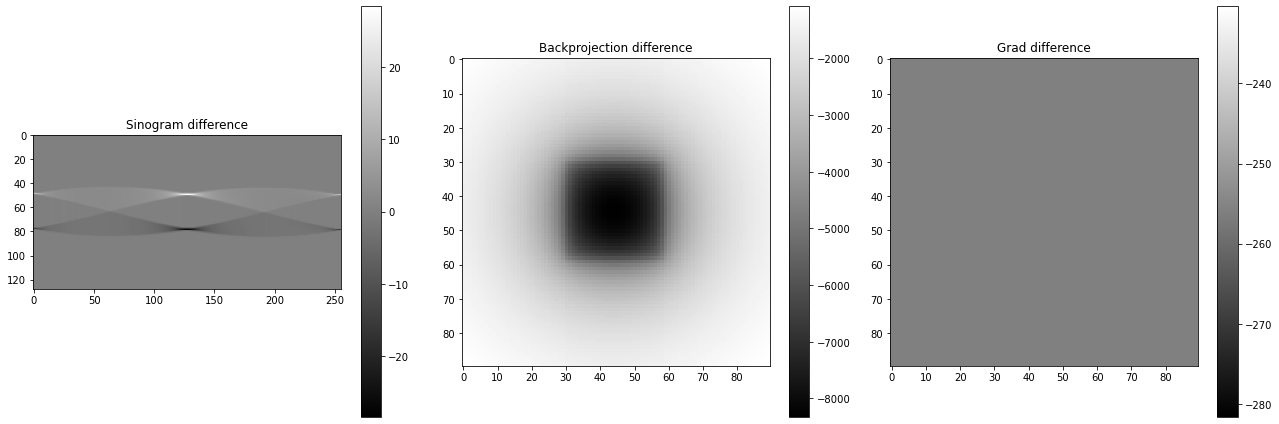

In [10]:
plt.subplots(1, 3, figsize=(18,6))
plt.subplot(1, 3, 1)
plt.title("Sinogram difference")
plt.imshow((sino4[0,0]-sino3.detach().to("cpu")[0,0]).mT, cmap="gray")
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("Backprojection difference")
plt.imshow((recon4[0,0]-recon3.detach().to("cpu")[0,0]), cmap="gray")
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("Grad difference")
plt.imshow((typing.cast(torch.Tensor, img4.grad).detach()[0,0]-typing.cast(torch.Tensor, img3.grad).detach().to("cpu")[0,0]), cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()